In [1]:
import cdms2 as cdms
import MV2 as MV
import cdtime,cdutil,genutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import string
import scipy.stats as stats
# Local solution
# If running remotely, uncomment the following code:
# %%bash
# git clone https://github.com/katemarvel/CMIP5_tools
# import CMIP5_tools as cmip5
import sys,os
sys.path.append("/Users/kmarvel/Google Drive/python-utils")

import CMIP5_tools as cmip5
import DA_tools
import Plotting

from eofs.cdms import Eof
from eofs.multivariate.cdms import MultivariateEof
%matplotlib inline

In [2]:

def fit_normals_to_data(C,**kwargs):
    a = kwargs.pop("a",None)
    ax = kwargs.pop("ax",None)
    if ax is None:
        ax=plt.gca()
    if a is None:
        a = np.max(np.abs(C))
        a = a + 0.5*a
    delta = a/25.
    xc = np.arange(-a,a+delta,delta)

    muc = np.ma.average(C)
    sigc = np.ma.std(C)
    fac = 1./sigc
    pdfc = stats.norm.pdf(xc,muc,sigc)
    ax.plot(xc,pdfc,**kwargs)


# Data
Regional monthly mean precipitation data has been calculated for the central/eastern Sahel (east of 0$^{\circ}$ longitude) and the western Sahel (west) in all CMIP5 models and three observational datasets.

In [3]:
cmip_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/CMIP5/INTENSITY/"
obs_directory = "/Users/kmarvel/Google Drive/Sahel/DATA/OBS/PROCESSED/"

Some helper functions: bootstrap_slopes calculates all (overlapping) L-year trends in a given time series.  Function by_month reshapes a monthly time series of shape (nt,) into one of shape(nt/12,12).

In [4]:
def bootstrap_slopes(noise,L=None,x=None):
    """Calculate the regression coefficients of length-L segments of a time series ("noise").  
    If x is not provided regress on time axis and return linear trend.  Otherwise regress on x and return coefficient"""
    if L is None:
        if x is None:
            raise TypeError("Error: must provide either L or x")
        else:
            L=len(x.getTime())
    nt=noise.shape[0]-L
    test = MV.zeros((nt,L))
    
    for i in range(nt):
        test[i]=noise[i:L+i]
    test.setAxis(1,noise[:L].getAxis(0))
    if x is None:
        return cmip5.get_linear_trends(test)  
    else:
        to_return=MV.zeros(nt)
        for i in range(nt):
            to_return[i]=float(genutil.statistics.linearregression(test[i],x=x)[0])
        return to_return
            


def by_month(X):
    """
    X is a cdat variable with a labeled time axis with time step = 1 month.
    This function returns variable with one extra axis with shape (12)
    """
    time_i=X.getAxisIds().index('time')
    nm=X.shape[time_i]
    nyears = int(nm/12)
    newtime=(nyears,12)
    d={}
    for i in range(len(X.shape)):
        d[i]=X.shape[i]
    d[time_i]=newtime
    #now make the new shape
    newshape=()
    for i in range(len(X.shape)):
        x=d[i]
        if type(x)==type(()):
            newshape+=x
        else:
            newshape+=(x,)
    Xr=MV.array(X.asma().reshape(newshape))
    axlist = range(len(X.shape))
    for i in axlist:
        if i != time_i:
            Xr.setAxis(i,X.getAxis(i)) 
    monthax = cdms.createAxis(np.arange(12)+1)
    monthax.id="months"
    monthax.months=str(["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"])
    Xr.setAxis(time_i+1,monthax)
    
    #yearax = cdms.createAxis(X.getTime()[0::12]) #####FIX 
    #for att in X.getTime().attributes:
    #    setattr(yearax,att,X.getTime().attributes[att])
    
   # yearax.id="time"
   # yearax.designateTime()
    yearax=cdutil.YEAR(X).getTime()
    Xr.setAxis(time_i,yearax)
    
    return Xr

            
def plot_multivariate(solver,i=0,fac=None,cmap=None):
    """Plot a multivariate EOF"""
    pr_CE_eofs,intensity_CE_eofs,pr_W_eofs,intensity_W_eofs=solver.eofs()
    if fac is None:
        fac=DA_tools.get_orientation(solver)
    if cmap is None:
        cmap=cm.PuOr
    plt.plot(pr_CE_eofs[i].asma()*fac,c=cmap(.9),label="East: precipitation")
    plt.plot(intensity_CE_eofs[i].asma()*fac,c=cmap(.8),ls=":",label="East: number of rainy days")

    plt.plot(pr_W_eofs[i].asma()*fac,c=cmap(.2),label="West: precipitation")
    plt.plot(intensity_W_eofs[i].asma()*fac,c=cmap(.1),ls=":",label="West: number of rainy days")
    months=["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]
    plt.xticks(np.arange(12),months)
    plt.legend()
    plt.axhline(0,c="k",ls=":")
    plt.ylabel("EOF loading")
    

In [ ]:

def normalize(data):
    if 'time' in data.getAxisIds():
        i=data.getAxisIds().index("time")
    else:
        raise TypeError("can't find time axis")

    sigmas=genutil.statistics.std(data,axis=i)
    return cmip5.cdms_clone((data/sigmas),data)
test=normalize(data)


Data and methods for CMIP5 model data.

In [ ]:
class CMIP5DATA():
    """
    Get east, west, and total Sahel precipitation data.  
    Experiment can be one of
    *1pctCO2
    *AA
    *historical
    *historicalGHG
    *historical-rcp85 (spliced)
    *piControl
    *rcp85
    """
    def __init__(self,experiment,base_period=None):
        if base_period is None:
            base_period=('1900-1-1','1950-12-31')
        f=cdms.open(cmip_directory+"cmip5.sahel_precip_intensity."+experiment+".nc")
        
        #total=f("pr_sahel")
        #f.close()
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        self.mma={}
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth(time=base_period),axis=1)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma()[:,np.newaxis,:],bymonth)
            self.anomalies[variable]=anomalies
            #multi-model average (first average over ensemble members, then models)
            mma=MV.average(cmip5.ensemble2multimodel(anomalies),axis=0)
            self.mma[variable]=mma
    def fingerprint(self,include=["pr_CE","intensity_CE","pr_W","intensity_W"],time_bounds=None):
        if time_bounds is None:
            time_bounds = (cmip5.start_time(self.mma["pr_CE"]),cmip5.stop_time(self.mma["pr_CE"]))
        if (type(include)==type("string")):
            
            solver=Eof(normalize(self.mma[include](time=time_bounds))
        else:
            data=[]
            for incl in include:
                data+=[normalize(self.mma[incl](time=time_bounds))]
                solver=MultivariateEof(data)
        solver.variables=include
        return solver
    
    def project_on_solver(self,projections_from=None,\
                          time_bounds=None,\
                          include=["pr_CE","intensity_CE","pr_W","intensity_W"],\
                          eof_number=0,\
                         plot_fingerprint=False):
        if projections_from is None:
            projections_from=self
        solver=self.fingerprint(include=include,time_bounds=time_bounds)
        if plot_fingerprint:
            plot_multivariate(fingerprint)
        fac=DA_tools.get_orientation(solver)
        nmod,nyears,nmonths=getattr(projections_from,"anomalies")["pr_CE"].shape
        P=MV.zeros((nmod,nyears))
        
        for modeli in range(nmod):
            
            if (type(include)==type("string")):
                to_proj=normalize(getattr(projections_from,"anomalies")[include][modeli])
                
            else:
                to_proj=[]
                for incl in include:
                    to_proj=normalize(getattr(projections_from,"anomalies")[incl][modeli])
                    
            P[modeli]=solver.projectField(to_proj)[:,eof_number]*fac
        P.setAxis(0,getattr(projections_from,"anomalies")["pr_CE"].getAxis(0))
        P.setAxis(1,getattr(projections_from,"anomalies")["pr_CE"].getAxis(1))
        return P
    
    def multivariate_to_project(self,i):
        include=["pr_CE","intensity_CE","pr_W","intensity_W"]
        to_proj=[]
        for incl in include:
            dat=self.anomalies[incl][i]
            to_proj+=[normalize(dat)]
        return to_proj
    def pseudoPC(self,projections_from=None,\
                          time_bounds=None,\
                          include=["pr_CE","intensity_CE","pr_W","intensity_W"],\
                          eof_number=0):
        if projections_from is None:
            projections_from=self
        solver=self.fingerprint(include=include,time_bounds=time_bounds)
        fac=DA_tools.get_orientation(solver)
        
       
        if (type(include)==type("string")):
            to_proj=normalize(getattr(projections_from,"mma")[include])
            
        else:
            to_proj=[]
            for incl in include:
                dat=getattr(projections_from,"mma")[incl]
                to_proj+=[normalize(dat)]
        P=solver.projectField(to_proj)[:,eof_number]*fac
        
        return P
        
            
        


In [ ]:
#LOAD THE DATA
h85=CMIP5DATA("historical-rcp85")

aa=CMIP5DATA("AA")

## Model selection
Because more models performed historical + rcp8.5 simulations than aerosol-only ones, we also need a class for h85 data from only these select models

In [177]:

aa_models=cmip5.models(aa.raw["pr_CE"])

h85_models=cmip5.models(h85.raw["pr_CE"])
aamod=[y.split(".")[1] for y in aa_models]
h85mod=[y.split(".")[1] for y in h85_models]
okmods=np.intersect1d(np.unique(aamod),np.unique(h85mod))
h85_keep=[]
for i in range(len(h85mod)):
    model = h85mod[i]
    if model in okmods:
        h85_keep+=[i]
newanoms={}
newmma={}
for key in h85.anomalies.keys():
    data=h85.anomalies[key]
    modax,tax,monthax=data.getAxisList()
    newdata=MV.array(data.asma()[np.array(h85_keep)])
    newmodax=cmip5.make_model_axis(np.array(h85_models)[np.array(h85_keep)].tolist())
    newdata.setAxisList([newmodax,tax,monthax])
    newdata.id=data.id
    newanoms[key]=newdata
    #print(cmip5.ensemble2multimodel(newdata).shape)
    newmma[key]=MV.average(cmip5.ensemble2multimodel(newdata),axis=0)
class SelectCMIP5DATA(CMIP5DATA):
    def __init__(self,experiment,newanoms,newmma):
        self.mma=newmma
        self.anomalies=newanoms
        
select_h85=SelectCMIP5DATA("historical-rcp85",newanoms,newmma) 

In [178]:
class PICONTROLDATA():
    """
    Get east, west, and total Sahel precipitation data.  
    Experiment can be one of
    *1pctCO2
    *AA
    *historical
    *historicalGHG
    *historical-rcp85 (spliced)
    *piControl
    *rcp85
    """
    def __init__(self):
        
        f=cdms.open(cmip_directory+"cmip5.sahel_precip_intensity.piControl.nc")
        
        #total=f("pr_sahel")
        #f.close()
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        self.concatenated={}
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth,axis=1)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma()[:,np.newaxis,:],bymonth)
            self.anomalies[variable]=anomalies
            #multi-model average (first average over ensemble members, then models)
            concatenated=DA_tools.concatenate_this(anomalies)
            self.concatenated[variable]=concatenated
    def fingerprint(self,include=["pr_CE","intensity_CE","pr_W","intensity_W"]):
        if (type(include)==type("string")):
            solver=Eof(self.concatenated(include))
        else:
            data=[]
            for incl in include:
                data+=[self.concatenated[incl]/np.std(self.concatenated[incl])]
                solver=MultivariateEof(data)
        solver.variables=include
        return solver
    
    def project_on_solver(self,solver,include=["pr_CE","intensity_CE","pr_W","intensity_W"],eof_number=0):
        #solver=self.fingerprint(include=include)
        fac=DA_tools.get_orientation(solver)
        nmod,nyears,nmonths=self.anomalies["pr_CE"].shape
        
        
        if type(include)==type("string"):
            dat=self.concatenated[include]
            to_proj=dat/np.std(dat)
        else:
            to_proj=[]
            for incl in include:
                dat=self.concatenated[incl]
                to_proj+=[dat/np.std(dat)]
        P=solver.projectField(to_proj)[:,eof_number]*fac
       
        return P
        
            

Project the pre-industrial control onto the solver to get a measure of noise

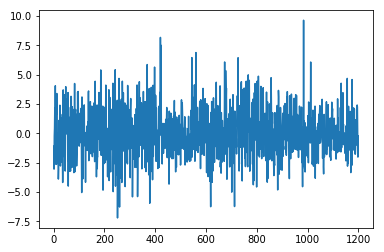

In [179]:
piC=PICONTROLDATA()
solver=h85.fingerprint()
picproj=piC.project_on_solver(solver)
Plotting.time_plot(picproj)

Leading noise mode: EOF1 of concatenated pre-industrial control simulations.  Compare this to the fingerprint and second EOF.

Text(0.5, 1.0, 'Third Noise Mode')

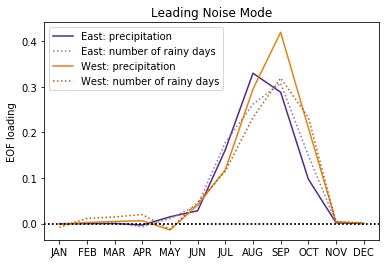

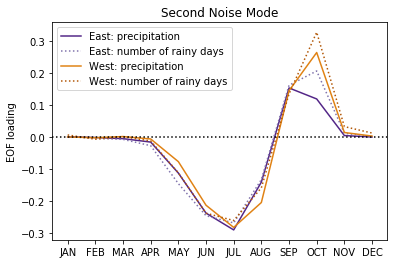

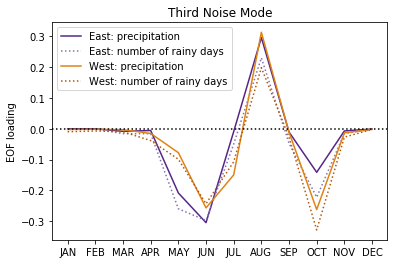

In [10]:
piC=PICONTROLDATA()
leading_noise_mode=piC.fingerprint()
plot_multivariate(leading_noise_mode,i=0)
plt.title("Leading Noise Mode")
plt.axhline(0,c="k",ls=":")
plt.figure()
plot_multivariate(leading_noise_mode,i=1)
plt.title("Second Noise Mode")
plt.figure()
plot_multivariate(leading_noise_mode,i=2)
plt.title("Third Noise Mode")

In [11]:
leading_noise_mode.varianceFraction()[:10]

variance_fraction
masked_array(data=[0.17235284, 0.12048984, 0.11376172, 0.08085117,
                   0.07421971, 0.06296972, 0.04924135, 0.0397137 ,
                   0.03769115, 0.03361456],
             mask=False,
       fill_value=1e+20)

# Observations
The fingerprint of a particular forcing or collection of forcings is calculated as the leading EOF of the multi-model mean of the CMIP5 simulations containing that forcing.

In [180]:
class OBS():
    def __init__(self,dataset,base_period=None):
        if base_period is None:
            base_period=('1900-1-1','1950-12-31')
        f=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/CMIP5/INTENSITY/cmip5.sahel_precip_intensity."+dataset+".nc")
        self.raw={}
        self.bymonth={}
        self.anomalies={}
        self.climatology={}
        
        for variable in ["pr_CE","intensity_CE","pr_W","intensity_W"]:
            #raw data
            data=f(variable)
            if variable in ["pr_CE","pr_W"]:
                #data=data
                data=data/(30*30.)
            self.raw[variable]=data
            #partitioned by month
            bymonth=by_month(data)
            self.bymonth[variable]=bymonth
            #climatology
            clim=MV.average(bymonth(time=base_period),axis=0)
            self.climatology[variable]=clim
            #anomalies
            anomalies=cmip5.cdms_clone(bymonth.asma()-clim.asma(),bymonth)
            self.anomalies[variable]=anomalies
        f.close()
    def project_on_solver(self,solver,include=["pr_CE","intensity_CE","pr_W","intensity_W"],eof_number=0):
        #solver=self.fingerprint(include=include)
        fac=DA_tools.get_orientation(solver)
        nyears,nmonths=self.anomalies["pr_CE"].shape
        to_proj=[]
        
        if type(include)==type("string"):
            to_proj=self.anomalies[include]
            to_proj=to_proj/np.std(to_proj)
        else:
            for incl in include:
                dat=self.anomalies[incl]
                to_proj+=[dat/np.std(dat)]
        P=solver.projectField(to_proj)[:,eof_number]*fac
       
        return P
            
CRU=OBS("CRU")

In [181]:
plot_linear_trends=False
if plot_linear_trends:
    Pcru_eof1=CRU.project_on_solver(h85.fingerprint(),eof_number=0)
    Pcru_ghg=CRU.project_on_solver(h85.fingerprint(),eof_number=0)
    Pcru_ghg_trunc=Pcru_ghg(time=('1950-1-1','1980-1-1'))
    Pcru_aa=CRU.project_on_solver(aa.fingerprint(),eof_number=0)

    Plotting.time_plot(Pcru_ghg,c="g")
    Plotting.time_plot(Pcru_ghg_trunc)

    noisecru=bootstrap_slopes(noiseh85,len(Pcru_ghg_trunc))
    plt.figure()
    plt.hist(noisecru,20,density=True,alpha=0.5)
    plt.axvline(cmip5.get_linear_trends(Pcru_ghg),c="r")
    modghg=h85.project_on_solver(time_bounds=('2000-1-1','2099-12-31'))\
        (time=(cmip5.start_time(Pcru_ghg_trunc),cmip5.stop_time(Pcru_ghg_trunc)))

    tmp=plt.hist(cmip5.get_linear_trends(modghg),20,density=True,alpha=0.5)
#Plotting.time_plot(Pcru_aa,c="k")
#Plotting.time_plot(Pcru_eof3)

In [182]:
class LinearDetector():
    def __init__(self,h85=None,aa=None,CRU=None,select_h85=None,include=["pr_CE","intensity_CE","pr_W","intensity_W"]):
        if h85 is None:
            self.h85=CMIP5DATA("historical-rcp85")
        else:
            self.h85=h85
        if aa is None:
            self.aa=CMIP5DATA("AA")
        else:
            self.aa=aa
        if CRU is None:
            self.CRU=OBS("CRU")
        else:
            self.CRU=CRU
        if select_h85 is not None:
            self.select_h85=select_h85

        self.start_time='1901-1-1'
        self.stop_time='2005-12-31'
        self.time_bounds=(self.start_time,self.stop_time)
        self.include=include
    def set_time_bounds(self,start_time=None,stop_time=None):
        if start_time is not None:
            self.start_time=start_time
        if stop_time is not None:
            self.stop_time=stop_time
        self.time_bounds=(self.start_time,self.stop_time)
        shaper_obs = self.CRU.anomalies["pr_CE"]
        shaper_obs=shaper_obs(time=self.time_bounds)
        self.L=shaper_obs.shape[0]
        
    def get_colors(self,typ):
        d={}
        d["obs"]=cm.Blues(.8)
        d["h85"]=cm.Greens(.8)
        d["select_h85"]=cm.Greens(.2)
        d["aa"]=cm.gray(.1)
        d["noise"] = cm.Reds(.9)
        return d[(typ.lower())]
    def get_obs_proj(self,experiment,fingerprint_time=None):
        fingerprint=getattr(self,experiment).fingerprint(time_bounds=fingerprint_time,include=self.include)
        
        Z_obs = self.CRU.project_on_solver(fingerprint,include=self.include)
        Z_obs=Z_obs(time=self.time_bounds)
        #PC=fingerprint.pcs()[:,0]*fac
        
       
        return Z_obs
    def obs_projection_slope(self,experiment,fingerprint_time=None):
        Z_obs=self.get_obs_proj(experiment,fingerprint_time=fingerprint_time)
        
        return cmip5.get_linear_trends(Z_obs)
        
        
    
    def get_model_projections(self,\
                              experiment,\
                              fingerprint_time=None,\
                              projections_from=None):
        
        fingerprint=getattr(self,experiment).fingerprint(time_bounds=fingerprint_time,include=self.include)
        
        if projections_from is None:
            projections_from=self.h85
        else:
            print("projections from ",projections_from)
            projections_from=getattr(self,projections_from)
            
        projections = getattr(self,experiment).project_on_solver(projections_from=projections_from,\
                          time_bounds=fingerprint_time,include=self.include)
        projections=projections(time=self.time_bounds)
        
        return projections
    
    def model_projection_slopes(self,\
                                      experiment,\
                                      fingerprint_time=None,\
                                      projections_from=None):
        
        projections=self.get_model_projections(experiment,\
                              fingerprint_time=fingerprint_time,\
                              projections_from=projections_from)
                                    
        #modsigs=[float(genutil.statistics.linearregression(Pi)[0]) for Pi in projections]
        #modsigs = MV.array(modsigs)
        #modsigs.setAxis(0,projections.getAxis(0))
        modsigs=cmip5.get_linear_trends(projections)
        return modsigs
    def get_noise_projections(self,\
                            experiment,\
                            fingerprint_time=None):
        fingerprint=getattr(self,experiment).fingerprint(time_bounds=fingerprint_time,include=self.include)
       
      
        noise=piC.project_on_solver(fingerprint,include=self.include)
        return noise
        
    def noise_slopes(self,\
                            experiment,\
                            fingerprint_time=None):
        noise=self.get_noise_projections(experiment,fingerprint_time=fingerprint_time)
        #noisesigs=bootstrap_slopes(noise,L=self.L)
        noisesigs=bootstrap_slopes(noise,L=self.L)
        return noisesigs
    def DA(self, experiment,\
           fingerprint_time=None,\
           start_time=None,\
           stop_time=None):
        self.set_time_bounds(start_time,stop_time)
        self.obs_signal=self.obs_projection_slope(experiment,\
                                            fingerprint_time=fingerprint_time)
        self.h85_signals=self.model_projection_slopes(experiment,\
                                      fingerprint_time=fingerprint_time,\
                                      projections_from="h85")
        if hasattr(self,"select_h85"):
            
            self.select_h85_signals=self.model_projection_slopes(experiment,\
                                          fingerprint_time=fingerprint_time,\
                                          projections_from="select_h85")
        aa_shape=self.aa.anomalies["pr_CE"](time=self.time_bounds).shape[0]  
        
        obs_shape=self.CRU.anomalies["pr_CE"](time=self.time_bounds).shape[0]  
        if aa_shape==obs_shape:
            self.aa_signals=self.model_projection_slopes(experiment,\
                                          fingerprint_time=fingerprint_time,\
                                          projections_from="aa")
        self.noise = self.noise_slopes(experiment, fingerprint_time=fingerprint_time)
        self.experiment=experiment
        
       
        
        
    def plot_DA(self,select=False):
        if not hasattr(self,"obs_signal"):
            raise TypeError("Need to run self.DA() first")
        tmp=plt.hist(self.noise.asma(),density=True,alpha=0.5,color=self.get_colors("noise"))
        fit_normals_to_data(self.noise,c=self.get_colors("noise"))
        
        tmp=plt.hist(self.h85_signals.asma(),\
                     density=True,\
                     alpha=0.5,\
                     color=self.get_colors("h85"),label="All forcings")
        fit_normals_to_data(self.h85_signals,c=self.get_colors("h85"))
        if hasattr(self,"aa_signals"):
            tmp=plt.hist(self.aa_signals.asma(),\
                         density=True,\
                         alpha=0.5,\
                         color=self.get_colors("aa"),label="AA only")
        if select:
            tmp=plt.hist(self.select_h85_signals.asma(),\
                     density=True,\
                     alpha=0.5,\
                     color=self.get_colors("select_h85"),label="All forcings (select)")
        plt.axvline(float(self.obs_signal),c=self.get_colors("obs"),label="CRU")
        plt.legend()
LINEAR=LinearDetector(h85=h85,aa=aa,CRU=CRU,select_h85=select_h85) 
LINEAR_PRE=LinearDetector(h85=h85,aa=aa,CRU=CRU,select_h85=select_h85,include="pr_CE") 
LINEAR_PRW=LinearDetector(h85=h85,aa=aa,CRU=CRU,select_h85=select_h85,include="pr_W") 
LINEAR_R1E=LinearDetector(h85=h85,aa=aa,CRU=CRU,select_h85=select_h85,include="intensity_CE") 
LINEAR_R1W=LinearDetector(h85=h85,aa=aa,CRU=CRU,select_h85=select_h85,include="intensity_W")

In [183]:
LINEAR_PRE.set_time_bounds("1950-1-1",'1979-12-31')
LINEAR_PRE.DA("h85", fingerprint_time=('1900-1-1','1999-12-31'))

projections from  h85
projections from  select_h85


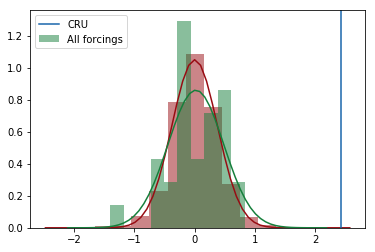

In [184]:
plt.figure()
LINEAR_PRE.plot_DA(select=False)

## Variance Fractions

In [150]:
cen20=h85.fingerprint(time_bounds=('1900-1-1','1999-12-31'))
cen21=h85.fingerprint(time_bounds=('2000-1-1','2099-12-31'))
aafp=aa.fingerprint()

print("AA",aafp.varianceFraction()[0])
print("20th Century",cen20.varianceFraction()[0])
print("21st Century",cen21.varianceFraction()[0])


AA 0.21907060939769957
20th Century 0.2712946805918385
21st Century 0.49807233772319204


## Model selection
How many models do we have aerosol-only data for?

correlation
masked_array(data=0.24357275,
             mask=False,
       fill_value=1e+20)

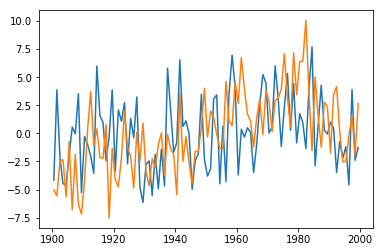

In [151]:
aapc=aafp.pcs()[:,0](time=('1900-1-1','1999-12-31'))
cen20pc=cen20.pcs()[:,0]
Plotting.time_plot(aapc)
Plotting.time_plot(cen20pc)

genutil.statistics.correlation(aapc,cen20pc)


In [57]:

cen20_select=select_h85.fingerprint(time_bounds=('1900-1-1','1999-12-31'))
cen21_select=select_h85.fingerprint(time_bounds=('2000-1-1','2099-12-31'))


In [58]:
def flatten_eof1(fingerprint):
    e1,e2,e3,e4=fingerprint.eofs()
    X=[e1[0],e2[0],e3[0],e4[0]]
    return np.array(X).flatten()

cen20_eof1=flatten_eof1(cen20)
cen21_eof1=flatten_eof1(cen21)

aa_eof1=flatten_eof1(aafp)

cen20_select_eof1=flatten_eof1(cen20_select)
cen21_select_eof1=flatten_eof1(cen21_select)


## Correlations between fingerprints
The AA fingerprint is NOT strongly correlated with the 20cen ALL fingerprint. The AA fingerprint shows a reduction in precipitation toward the end of the rainy season, with peak reductions in Sept and Oct.  The 20cen fingerprint shows a reduction in precip earlier in the rainy season.

correlation is 0.4965372434364286
projection is 0.6468595316946903


Text(0.5, 1.0, '20Cen fingerprint (ALL models)')

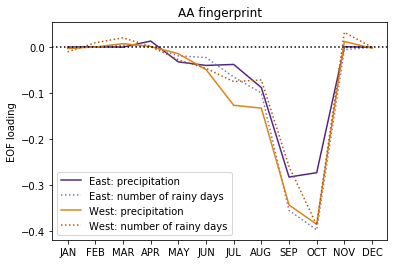

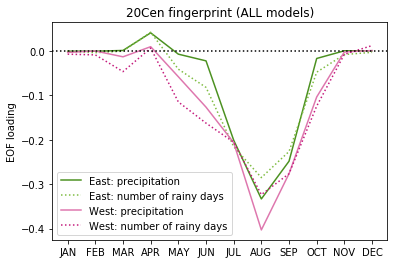

In [59]:
print("correlation is", np.corrcoef(aa_eof1,cen20_eof1)[0,1])
print("projection is", np.dot(aa_eof1,cen20_eof1))

plot_multivariate(aafp)
plt.title("AA fingerprint")
plt.figure()
plot_multivariate(cen20,cmap=cm.PiYG)
plt.title("20Cen fingerprint (ALL models)")

This isn't due to any real difference in the climatologies in the different models.

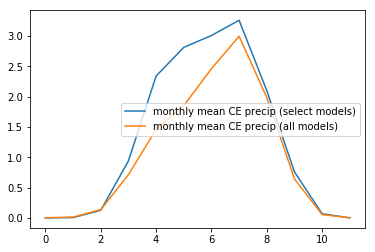

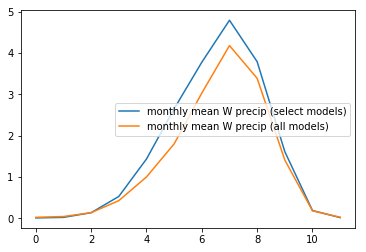

In [60]:
plt.plot(MV.average(aa.climatology["pr_CE"],axis=0).asma(),\
         label="monthly mean CE precip (select models)")
plt.plot(MV.average(h85.climatology["pr_CE"],axis=0).asma(),\
         label="monthly mean CE precip (all models)")
plt.legend()
plt.figure()
plt.plot(MV.average(aa.climatology["pr_W"],axis=0).asma(),\
         label="monthly mean W precip (select models)")
plt.plot(MV.average(h85.climatology["pr_W"],axis=0).asma(),\
         label="monthly mean W precip (all models)")
plt.legend()

The AA fingerprint IS strongly correlated with the 20 cen SELECT fingerprint

correlation is -0.9564463339172811
projection is -0.9680129408607695


Text(0.5, 1.0, '20Cen fingerprint (Select models)')

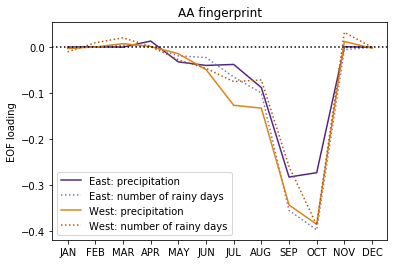

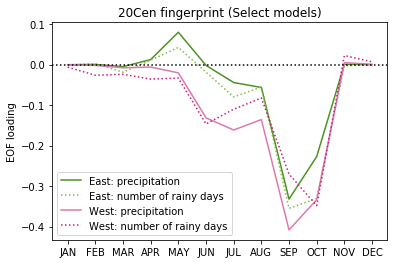

In [61]:
print("correlation is", np.corrcoef(aa_eof1,cen20_select_eof1)[0,1])
print("projection is", np.dot(cen20_select_eof1,aa_eof1))
plot_multivariate(aafp)
plt.title("AA fingerprint")
plt.figure()
plot_multivariate(cen20_select,cmap=cm.PiYG)
plt.title("20Cen fingerprint (Select models)")

# Single-variable fingerprints and times of emergence

In [185]:
include=["pr_CE","intensity_CE","pr_W","intensity_W"]
SOLVERS20={}
SOLVERS21={}
SOLVERSAA={}
for variable in include:
    SOLVERS20[variable]=h85.fingerprint(time_bounds=('1900-1-1','1999-12-31'),include=variable)
    SOLVERS21[variable]=h85.fingerprint(time_bounds=('2000-1-1','2099-12-31'),include=variable)
    SOLVERSAA[variable]=aa.fingerprint(include=variable)
    

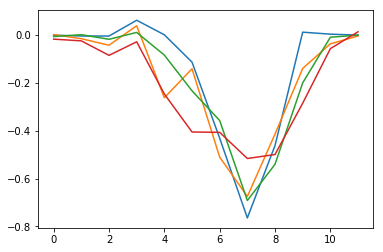

In [186]:
for key in SOLVERS20.keys():
    solver=SOLVERS20[key]
    fac=da.get_orientation(solver)
    eof1=solver.eofs()[0]
    plt.plot(fac*eof1.asma())

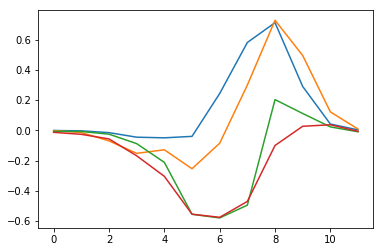

In [187]:
for key in SOLVERS21.keys():
    solver=SOLVERS21[key]
    fac=da.get_orientation(solver)
    eof1=solver.eofs()[0]
    plt.plot(fac*eof1.asma())

In [188]:
def noiseterms_for_SN(solver,include=["pr_CE","intensity_CE","pr_W","intensity_W"]):
    noise=piC.project_on_solver(solver,include=include)
    denom=np.ma.zeros(200)
    for L in np.arange(200)[2:]:
        
        slopes=bootstrap_slopes(noise,L)
        sigma=np.std(slopes)
        denom[L]=sigma
    denom=np.ma.masked_where(denom==0,denom)
    return denom
    

In [189]:
NOISETERMS_INDIVIDUAL_20={}
NOISETERMS_INDIVIDUAL_21={}
include=["pr_CE","intensity_CE","pr_W","intensity_W"]
for variable in include:
    solver20=SOLVERS20[variable]
    solver21=SOLVERS21[variable]
    NOISETERMS_INDIVIDUAL_20[variable]=noiseterms_for_SN(solver20,include=variable)
    NOISETERMS_INDIVIDUAL_21[variable]=noiseterms_for_SN(solver21,include=variable)
NOISETERMS_INDIVIDUAL_20["all"]=noiseterms_for_SN(cen20,include=include)
NOISETERMS_INDIVIDUAL_21["all"]=noiseterms_for_SN(cen21,include=include)

In [190]:
tax=cdms.createAxis(np.arange(200))
tax.designateTime()
tax.units="years since 0001-1-1"
f20=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/noise20cen.nc","w")
for key in NOISETERMS_INDIVIDUAL_20.keys():
    data=MV.array(NOISETERMS_INDIVIDUAL_20[key])
    data.id=key
    data.setAxis(0,tax)
    f20.write(data)
f20.close()
    
    
    

In [191]:
f21=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/noise21cen.nc","w")
for key in NOISETERMS_INDIVIDUAL_21.keys():
    data=MV.array(NOISETERMS_INDIVIDUAL_21[key])
    data.id=key
    data.setAxis(0,tax)
    f21.write(data)
f21.close()

In [192]:
def signals_for_SN(projections):
    nmod,nyears=projections.shape
    
    starttime=cdtime.comptime(1900,1,1)
    endtime=starttime.add(2,cdtime.Years)
    y2100=cdtime.comptime(2099,12,31)
    yrs=2100-endtime.year+1
    signals=np.ma.zeros((nmod,200))
    
    counter=2
    while endtime.cmp(y2100)<=0:
        
        trunc=projections(time=(starttime,endtime))
        L=trunc.shape[1]
        signals[:,counter]=cmip5.get_linear_trends(trunc)
        endtime=endtime.add(1,cdtime.Years)
        counter+=1
    data=MV.masked_where(signals==0,signals)
    data.setAxisList(projections.getAxisList())
        

In [193]:
f20=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/signals20cen.nc","w")
for variable in include:
    projections20=h85.project_on_solver(time_bounds=('1900-1-1','1999-12-31'),include=variable)
    projections20.id=variable
    f20.write(projections20)
projections20=h85.project_on_solver(time_bounds=('1900-1-1','1999-12-31'),include=include)
projections20.id="all"
f20.write(projections20)
f20.close()
    

In [194]:
f21=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/signals21cen.nc","w")
for variable in include:
    projections21=h85.project_on_solver(time_bounds=('2000-1-1','2099-12-31'),include=variable)
    projections21.id=variable
    f21.write(projections21)
projections21=h85.project_on_solver(time_bounds=('2000-1-1','2099-12-31'),include=include)
projections21.id="all"
f21.write(projections21)
f21.close()

In [195]:
def plot_signal_to_noise(variable,century,**kwargs):
    fsignal=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/signals"+str(century)+"cen.nc")
    signals=fsignal(variable)
    fnoise=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/noise"+str(century)+"cen.nc")
    noise=fnoise(variable)
    fsignal.close()
    fnoise.close()
    SN=MV.average(signals,axis=0)/noise
    xax=np.arange(200)+1901
    plt.plot(xax,SN.asma(),**kwargs)
    plt.ylabel("S/N ratio")
    plt.xlabel("Trend end year")

(0, 1)

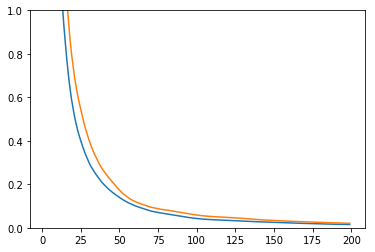

In [214]:
def plot_noise(variable,century):
    fnoise=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/noise"+str(century)+"cen.nc")
    noise=fnoise(variable)
    plt.plot(noise.asma())
plot_noise("intensity_W",21)
plot_noise("all",21)

plt.ylim(0,1)

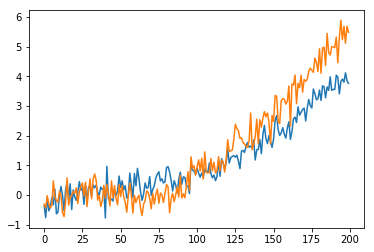

In [211]:
def plot_signal(variable,century):
    fsignal=cdms.open("/Users/kmarvel/Google Drive/Sahel/DATA/SN/signals"+str(century)+"cen.nc")
    signal=fsignal(variable)
    plt.plot(MV.average(signal,axis=0).asma())
    fsignal.close()
plot_signal("intensity_W",21)
plot_signal("all",21)

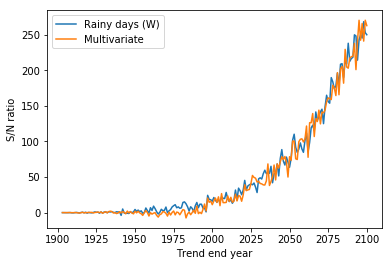

In [215]:
#plot_signal_to_noise("intensity_CE",21,label="Rainy days (CE)")
plot_signal_to_noise("intensity_W",21,label="Rainy days (W)")
#plot_signal_to_noise("pr_CE",21,label="Mean precip (E)")
#plot_signal_to_noise("pr_W",21,label="Mean precip (W)")
plot_signal_to_noise("all",21,label="Multivariate")
plt.legend()


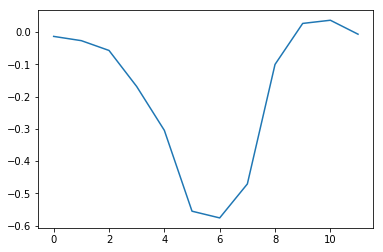

In [198]:
plt.plot(SOLVERS21["intensity_W"].eofs()[0].asma())

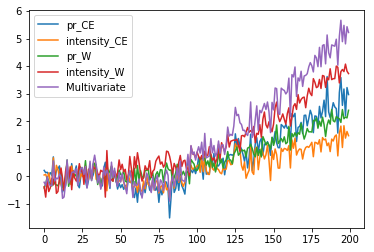

In [207]:
[plt.plot(MV.average(h85.project_on_solver(include=variable),axis=0).asma(),label=variable) for variable in include]
plt.plot(MV.average(h85.project_on_solver(),axis=0).asma(),label="Multivariate")
plt.legend()

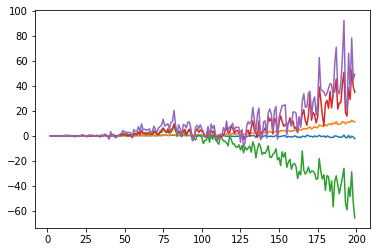

In [123]:
plot_signal_to_noise("intensity_CE",20)
plot_signal_to_noise("intensity_W",20)
plot_signal_to_noise("pr_CE",20)
plot_signal_to_noise("pr_W",20)
plot_signal_to_noise("all",20)

In [127]:

NOISETERMS_INDIVIDUAL_AA={}

include=["pr_CE","intensity_CE","pr_W","intensity_W"]
for variable in include:
    solveraa=SOLVERSAA[variable]
    
    NOISETERMS_INDIVIDUAL_AA[variable]=noiseterms_for_SN(solveraa,include=variable)
    
NOISETERMS_INDIVIDUAL_AA["all"]=noiseterms_for_SN(aafp,include=include)


In [222]:
proj_intensity_w=piC.project_on_solver(SOLVERS21["intensity_W"],include="intensity_W")
proj_all=piC.project_on_solver(cen21,include=["pr_CE","intensity_CE","pr_W","intensity_W"])
#Plotting.time_plot(piC.project_on_solver(SOLVERS21["intensity_CE"],include="intensity_CE"))

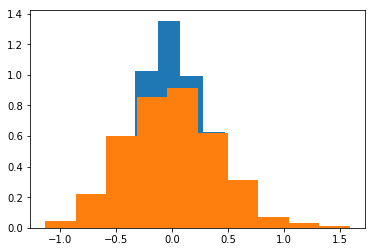

In [227]:
tmp=plt.hist(bootstrap_slopes(proj_intensity_w,30).asma(),density=True)
tmp=plt.hist(bootstrap_slopes(proj_all,30).asma(),density=True)

In [233]:
print(np.argmax(proj_all))
print(np.argmax(proj_intensity_w))
plt.plot(piC.concatenated["intensity_W"])

984
587


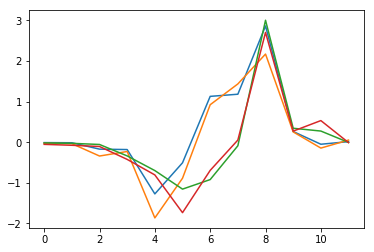

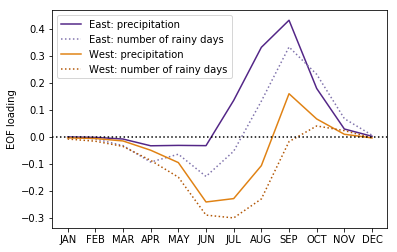

In [235]:
[plt.plot(piC.concatenated[variable][984].asma()/np.std(piC.concatenated[variable][984].asma())) for variable in include]
plt.figure()
plot_multivariate(cen21)

In [252]:
test_noise=[]
test_noise_intensity_W=[]
for i in range(1200):
    to_proj=[piC.concatenated[variable][i]/np.std(piC.concatenated[variable][i]) for variable in include]

    test_noise+=[float(cen21.projectField(to_proj)[0]*da.get_orientation(cen21))]
    to_proj_w=piC.concatenated["intensity_W"][i]/np.std(piC.concatenated["intensity_W"][i])
    solver21=SOLVERS21["intensity_W"]
    test_noise_intensity_W+=[float(solver21.projectField(to_proj_w)[0])]

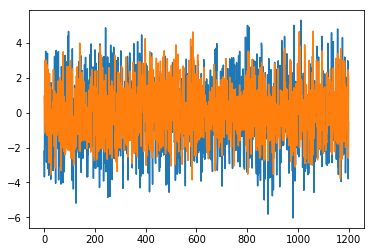

In [253]:
plt.plot(test_noise)
plt.plot(test_noise_intensity_W)